# Inicio

El objetivo del proyecto es predecir aquellos clientes con mayor propensión a abrir un mail de marketing sobre la adquisición de tarjetas de crédito por parte de una entidad bancaria

Para eso se utilizarán datos históricos para el entrenamiento

Negocio nos dice que tuvo un equipo de científicos previamente que obtuvo unas métricas que pueden verse a continuación. Sugiere que deberíamos intentar conseguir, al menos, algo similar.

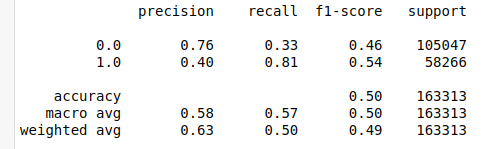

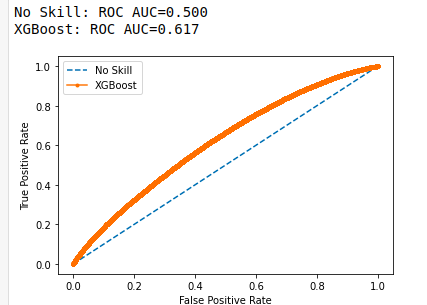

# Análisis Exploratorio de Datos

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
def calculate_roc(testy,lr_probs):
    # calculate scores
    ns_probs = [0 for _ in range(len(testy))]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Carga del Dataset

In [3]:
df = pd.read_csv('d:/Python/DatasetModulo2.csv')

In [4]:
pd.set_option('display.max_columns',500)

## Análisis Inicial del Dataset y Target

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494887 entries, 0 to 494886
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   FechaSaldos                    494887 non-null  object 
 1   periodo_cli                    494887 non-null  int64  
 2   periodo                        494887 non-null  int64  
 3   cant_productos                 494887 non-null  int64  
 4   cant_PF                        494887 non-null  int64  
 5   cant_TC                        494887 non-null  int64  
 6   cant_PP                        494887 non-null  int64  
 7   FechaUltMovCA                  468164 non-null  object 
 8   cant_seguros                   494887 non-null  int64  
 9   importe_consumos               494887 non-null  int64  
 10  Edad                           494887 non-null  int64  
 11  Sexo                           494887 non-null  object 
 12  SaldoPromedioCAPesos          

In [6]:
df.target.value_counts(normalize=True)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [7]:
df.target2.value_counts(normalize=True)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

## Análisis de Valores Nulos, Faltantes, erróneos

In [8]:
df.Sexo.value_counts(dropna=False)

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [9]:
df.Sexo = df.Sexo.str.replace(' ','Na')

In [10]:
[col for col in df.columns if df[col].isna().any()==True]

['FechaUltMovCA',
 'FechaVinculacion',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2',
 'score_deuda']

In [11]:
df.score_deuda.fillna(0,inplace=True)

In [12]:
df.CategoriaProducto.value_counts(normalize=True,dropna=False)

14    0.517437
10    0.208884
12    0.177483
28    0.031868
19    0.020118
18    0.015377
3     0.007640
15    0.004710
9     0.002942
26    0.002762
27    0.002754
22    0.002750
7     0.001473
16    0.001113
6     0.000705
23    0.000430
13    0.000309
25    0.000299
20    0.000293
17    0.000228
5     0.000133
11    0.000109
1     0.000079
4     0.000034
24    0.000024
8     0.000016
2     0.000012
21    0.000010
0     0.000004
Name: CategoriaProducto, dtype: float64

In [13]:
to_keep = df.CategoriaProducto.value_counts(normalize=True,dropna=False)[:3].index

In [14]:
to_keep

Int64Index([14, 10, 12], dtype='int64')

In [15]:
df.CategoriaProducto.fillna('OTH',inplace=True)

In [16]:
df.CategoriaProducto = df.CategoriaProducto.apply(lambda x:'OTH' if x not in to_keep else x)

In [17]:
df.CategoriaProducto.value_counts()

14     256073
10     103374
12      87834
OTH     47606
Name: CategoriaProducto, dtype: int64

In [18]:
df.FechaSaldos = pd.to_datetime(df.FechaSaldos)

In [19]:
df.FechaUltMovCA = pd.to_datetime(df.FechaUltMovCA)

In [20]:
df.FechaVinculacion = pd.to_datetime(df.FechaVinculacion)

In [21]:
df[df.FechaVinculacion.isna()]['target2'].value_counts()

0.0    46403
1.0    32861
Name: target2, dtype: int64

In [22]:
df[df.FechaUltMovCA.isna()]['target2'].value_counts()

0.0    15337
1.0    11386
Name: target2, dtype: int64

In [23]:
df.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [24]:
df.FechaUltMovCA.mode()

0   2019-12-05
dtype: datetime64[ns]

In [25]:
df['FechaUltMovCA'].describe()

count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object

In [26]:
df.loc[df.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-09-20')

In [27]:
(df.FechaVinculacion.dt.year - datetime.now().year)

0        -3.0
1        -5.0
2         NaN
3         NaN
4         NaN
         ... 
494882   -6.0
494883   -4.0
494884   -2.0
494885   -2.0
494886   -1.0
Name: FechaVinculacion, Length: 494887, dtype: float64

In [28]:
df['antiguedad']=(df.FechaVinculacion.dt.year - datetime.now().year)*-1

In [29]:
df.loc[df['antiguedad'].isna(),'antiguedad']=df.antiguedad.mean()

In [30]:
df.drop(columns='FechaVinculacion',inplace=True)

In [31]:
[col for col in df.columns if df[col].isna().any()==True]

['SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2']

In [32]:
df.fillna(0,inplace=True)

In [33]:
df.drop(columns='target',inplace=True)

# Acá empieza lo de Nico

# Veamos el tema correlación

In [34]:
Saldos = df[['SaldoPromedioCAPesos','SaldoPromedioCADolares','SaldoPromedioCCAcreedor'
             ,'SaldoPromedioCAPesos_ant_1','SaldoPromedioCADolares_ant_1'
             ,'SaldoPromedioCCAcreedor_ant_1','SaldoPromedioCAPesos_ant_2'
             ,'SaldoPromedioCADolares_ant_2','SaldoPromedioCCAcreedor_ant_2']].copy()

In [35]:
Cantidades = df[['cant_productos','cant_PF','cant_TC','cant_PP','cant_seguros','cant_PF_ant_1'
              ,'cant_TC_ant_1','cant_PP_ant_1','cant_PF_ant_2','cant_TC_ant_2','cant_PP_ant_2']].copy()

In [36]:
Importes = df[['importe_consumos','importe_consumos_ant_1','importe_consumos_ant_2']].copy()

In [37]:
Totales = df[['TotalConsumoTD','TotalConsumoTD_ant_1','TotalConsumoTD_ant_2']].copy()

### Correlación entre saldos

In [38]:
Saldos.corr()

,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2
SaldoPromedioCAPesos,1.000000,0.123816,-0.002415,0.894747,0.124447,-0.002011,0.856130,0.129750,-0.002303
SaldoPromedioCADolares,0.123816,1.000000,0.024022,0.112070,0.928429,0.019723,0.111328,0.827414,0.022737
SaldoPromedioCCAcreedor,-0.002415,0.024022,1.000000,-0.002217,0.023822,0.925373,-0.002365,0.023185,0.895986
SaldoPromedioCAPesos_ant_1,0.894747,0.112070,-0.002217,1.000000,0.113034,-0.002108,0.882303,0.115242,-0.002127
SaldoPromedioCADolares_ant_1,0.124447,0.928429,0.023822,0.113034,1.000000,0.019602,0.113426,0.920559,0.022711
SaldoPromedioCCAcreedor_ant_1,-0.002011,0.019723,0.925373,-0.002108,0.019602,1.000000,-0.002499,0.019002,0.906964
SaldoPromedioCAPesos_ant_2,0.856130,0.111328,-0.002365,0.882303,0.113426,-0.002499,1.000000,0.115273,-0.002356
SaldoPromedioCADolares_ant_2,0.129750,0.827414,0.023185,0.115242,0.920559,0.019002,0.115273,1.000000,0.022079
SaldoPromedioCCAcreedor_ant_2,-0.002303,0.022737,0.895986,-0.002127,0.022711,0.906964,-0.002356,0.022079,1.000000


In [39]:
df.drop(columns=['SaldoPromedioCAPesos_ant_1','SaldoPromedioCADolares_ant_1'
                  ,'SaldoPromedioCCAcreedor_ant_1','SaldoPromedioCAPesos_ant_2'
                  ,'SaldoPromedioCADolares_ant_2','SaldoPromedioCCAcreedor_ant_2'],inplace=True)

### Correlación entre Cantidades

In [40]:
Cantidades.corr()

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2
cant_productos,1.000000,0.415529,0.776516,0.240124,0.136197,0.276232,0.768842,0.232098,0.283960,0.761113,0.227373
cant_PF,0.415529,1.000000,0.020275,-0.028698,0.000155,0.647145,0.020479,-0.028823,0.653027,0.020557,-0.028659
cant_TC,0.776516,0.020275,1.000000,0.016999,0.092299,0.018731,0.986346,0.019066,0.024007,0.974046,0.020885
cant_PP,0.240124,-0.028698,0.016999,1.000000,0.127039,-0.027343,0.019749,0.957408,-0.032762,0.022191,0.931638
cant_seguros,0.136197,0.000155,0.092299,0.127039,1.000000,0.001733,0.094222,0.127813,0.003247,0.095159,0.128683
cant_PF_ant_1,0.276232,0.647145,0.018731,-0.027343,0.001733,1.000000,0.018987,-0.027327,0.711174,0.018963,-0.027555
cant_TC_ant_1,0.768842,0.020479,0.986346,0.019749,0.094222,0.018987,1.000000,0.021784,0.024181,0.985574,0.023701
cant_PP_ant_1,0.232098,-0.028823,0.019066,0.957408,0.127813,-0.027327,0.021784,1.000000,-0.032866,0.024043,0.953628
cant_PF_ant_2,0.283960,0.653027,0.024007,-0.032762,0.003247,0.711174,0.024181,-0.032866,1.000000,0.024332,-0.033081
cant_TC_ant_2,0.761113,0.020557,0.974046,0.022191,0.095159,0.018963,0.985574,0.024043,0.024332,1.000000,0.026197


In [41]:
df.drop(columns=['cant_productos','cant_PF_ant_1','cant_TC_ant_1'
                 ,'cant_PP_ant_1','cant_PF_ant_2','cant_TC_ant_2','cant_PP_ant_2'],inplace=True)

### Correlación entre Cantidades

In [42]:
Importes.corr()

,importe_consumos,importe_consumos_ant_1,importe_consumos_ant_2
importe_consumos,1.000000,0.856026,0.679518
importe_consumos_ant_1,0.856026,1.000000,0.827102
importe_consumos_ant_2,0.679518,0.827102,1.000000


In [43]:
df.drop(columns=['importe_consumos_ant_1','importe_consumos_ant_2'],inplace=True)

### Correlación entre Totales

In [44]:
Totales.corr()

,TotalConsumoTD,TotalConsumoTD_ant_1,TotalConsumoTD_ant_2
TotalConsumoTD,1.000000,0.710070,0.683206
TotalConsumoTD_ant_1,0.710070,1.000000,0.727118
TotalConsumoTD_ant_2,0.683206,0.727118,1.000000


In [45]:
df.drop(columns=['TotalConsumoTD_ant_1','TotalConsumoTD_ant_2'],inplace=True)

## Chequeo outliers

In [46]:
for col in df.select_dtypes('number').columns:
    print(col,sum(df[col]>df[col].quantile(0.95)))

periodo_cli 14014
periodo 14014
cant_PF 12685
cant_TC 10671
cant_PP 10084
cant_seguros 23866
importe_consumos 355
Edad 24146
SaldoPromedioCAPesos 24745
SaldoPromedioCADolares 24745
SaldoPromedioCCAcreedor 18656
TotalConsumoTD 24745
TipoCuentaAcredHab 0
cuotas_faltantes_1 24386
cuotas_faltantes 24676
cuotas_faltantes_2 24685
score_deuda 10107
target2 0
antiguedad 16655


In [47]:
def remove_outlier(col_name,veces_el_rango):
       q1 = col_name.quantile(0.25)
       q3 = col_name.quantile(0.75)
       iqr = q3-q1 #Interquartile range
       fence_high = q3+veces_el_rango*iqr
       return fence_high

In [48]:
Mas_de_1000 = df[['periodo_cli','periodo','cant_PF','cant_TC','cant_PP'                 
                  ,'score_deuda',]].copy()
Mas_de_1500 = df[['SaldoPromedioCCAcreedor','antiguedad']].copy()
Mas_de_2000 = df[['cant_seguros','Edad','SaldoPromedioCAPesos','SaldoPromedioCADolares'
                 ,'TotalConsumoTD','cuotas_faltantes_1','cuotas_faltantes','cuotas_faltantes_2']].copy()

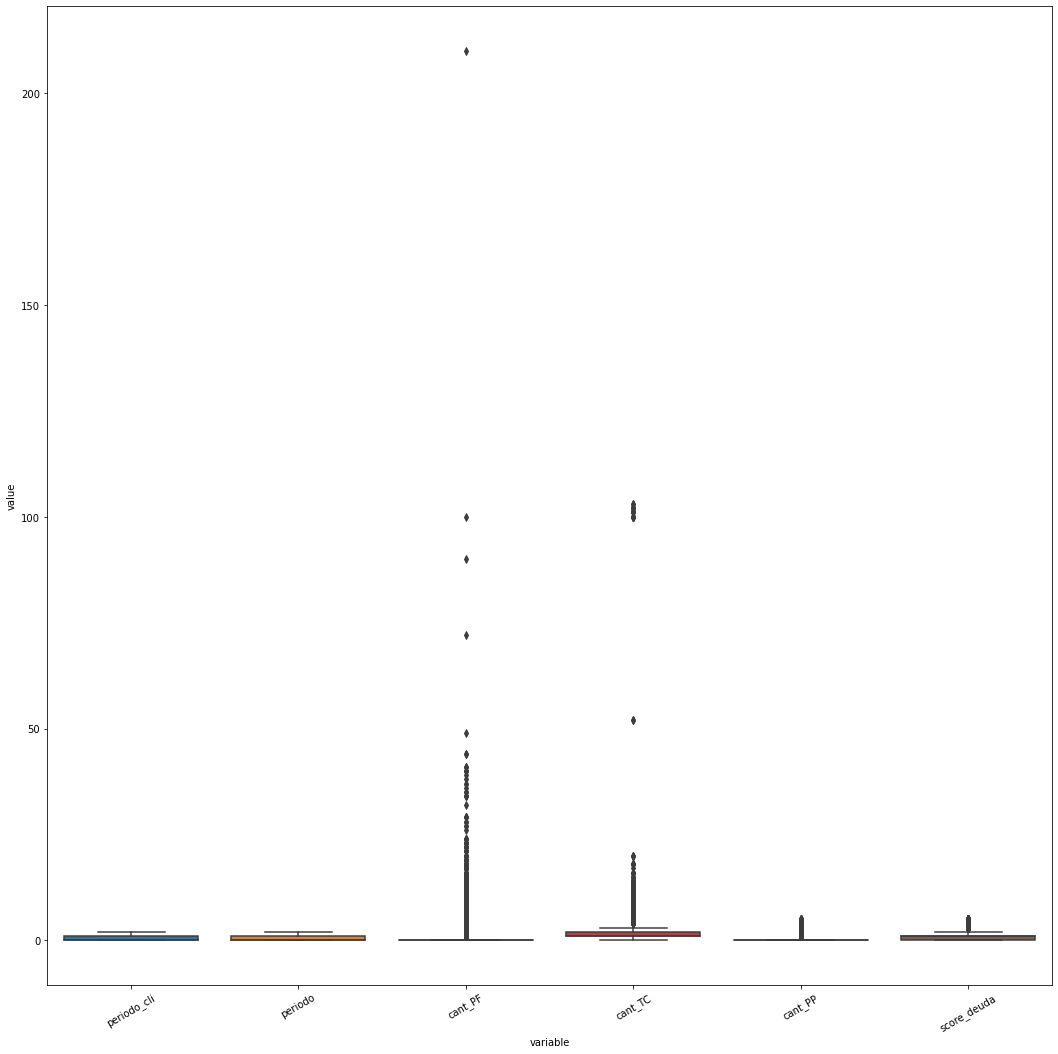

In [49]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mas_de_1000))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

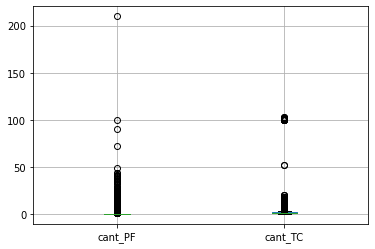

In [50]:
df[['cant_PF','cant_TC']].boxplot()

In [51]:
df = df[df['cant_PF']<df['cant_PF'].quantile(0.95)]

In [52]:
df = df[df['cant_TC']<df['cant_TC'].quantile(0.95)]

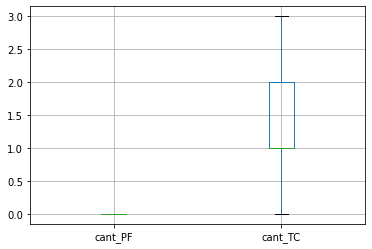

In [53]:
df[['cant_PF','cant_TC']].boxplot()

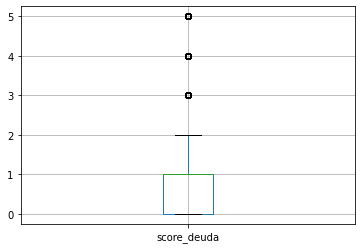

In [54]:
df[['score_deuda']].boxplot()

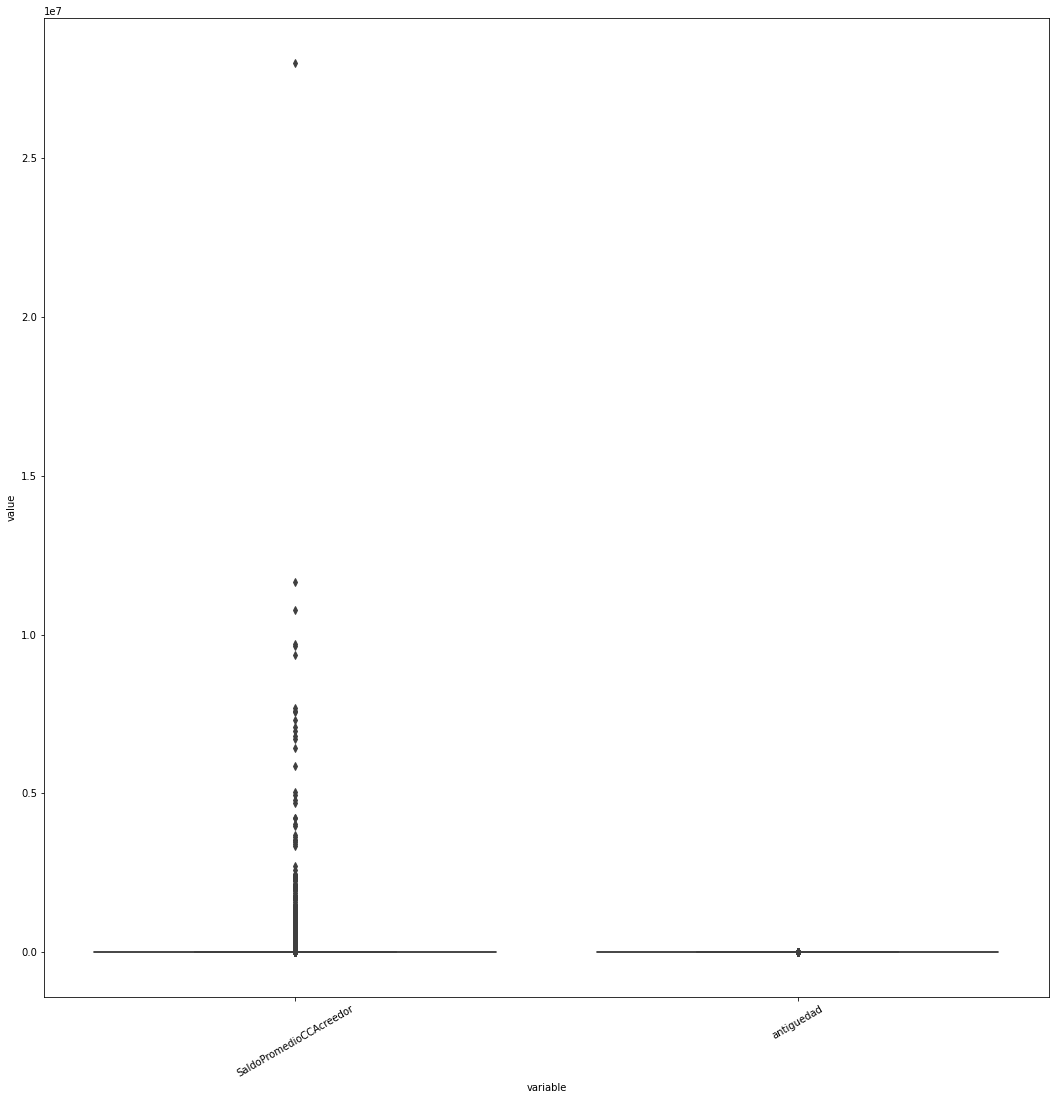

In [55]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mas_de_1500))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

### (Mirar bien después en la importancia que le da el modelo)

In [56]:
df[['SaldoPromedioCCAcreedor','SaldoPromedioCAPesos']].describe()

,SaldoPromedioCCAcreedor,SaldoPromedioCAPesos
count,4.298050e+05,4.298050e+05
mean,1.456406e+03,3.238015e+04
std,6.633424e+04,9.678800e+04
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.175160e+03
50%,0.000000e+00,1.184027e+04
75%,0.000000e+00,3.175529e+04
max,2.801730e+07,9.412126e+06


## Mas de 2000

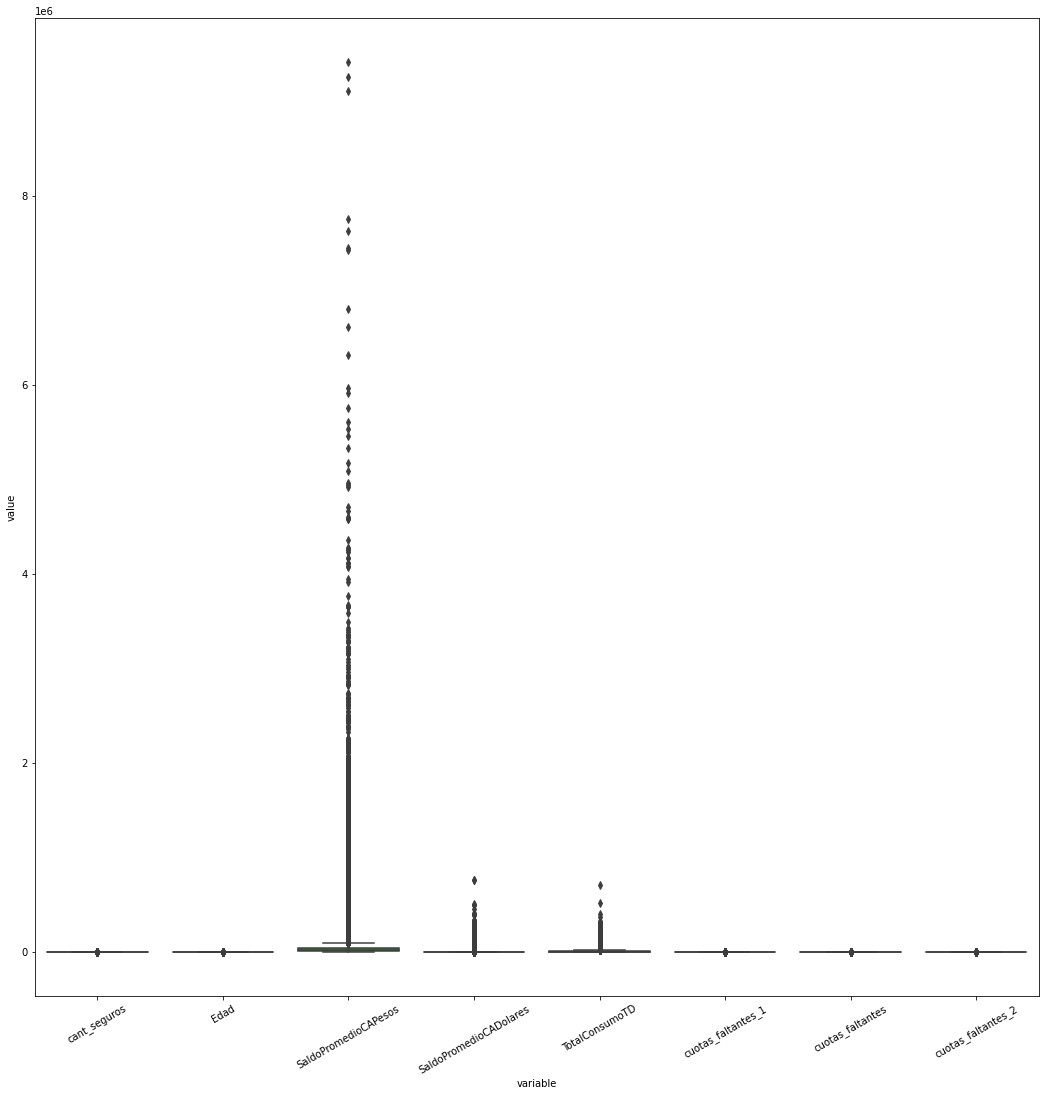

In [57]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mas_de_2000))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [58]:
df[['SaldoPromedioCADolares','TotalConsumoTD']].describe()

,SaldoPromedioCADolares,TotalConsumoTD
count,429805.000000,429805.000000
mean,482.772902,5167.160057
std,4572.173731,10179.863323
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,6520.000000
max,757470.680000,706683.480000


In [59]:
df = df[df['TotalConsumoTD']<remove_outlier(df['TotalConsumoTD'],2)]

In [60]:
df['SaldoPromedioCADolares'].quantile(0.95)

1116.2475

In [61]:
df = df[df['SaldoPromedioCADolares']<df['SaldoPromedioCADolares'].quantile(0.95)]

In [62]:
df[['cant_seguros','cuotas_faltantes_1','cuotas_faltantes','cuotas_faltantes_2']].describe()

,cant_seguros,cuotas_faltantes_1,cuotas_faltantes,cuotas_faltantes_2
count,376034.000000,376034.000000,376034.000000,376034.000000
mean,0.409357,9.263380,9.156728,9.361164
std,0.831709,28.477626,28.279369,28.679864
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,18.000000,351.000000,348.000000,355.000000


In [63]:
df[['cuotas_faltantes_1','cuotas_faltantes','cuotas_faltantes_2']].corr()

,cuotas_faltantes_1,cuotas_faltantes,cuotas_faltantes_2
cuotas_faltantes_1,1.000000,0.994650,0.994397
cuotas_faltantes,0.994650,1.000000,0.989094
cuotas_faltantes_2,0.994397,0.989094,1.000000


In [64]:
df.drop(columns=['cuotas_faltantes_2','cuotas_faltantes_1'],inplace=True)

In [75]:
#df = df[df['cant_TC']<remove_outlier(df['cant_TC'])]

In [76]:
#df = df[df['cant_productos']<remove_outlier(df['cant_productos'])]

In [77]:
df.shape

(376034, 21)

In [78]:
df.shape

(376034, 21)

# Acá termina lo de Nico

## Estudio de Distribución individual de los datos

In [79]:
all(df.periodo == df.periodo_cli)

True

In [80]:
df.drop(columns='periodo',inplace=True)

In [81]:
df[df.Edad<=18]['target2'].value_counts()

0.0    857
1.0    644
Name: target2, dtype: int64

In [82]:
df=df[df.Edad>18].copy()

In [83]:
df.shape

(374533, 20)

In [84]:
[col for col in df.columns if df[col].nunique()==1]

['cant_PF', 'TipoCuentaAcredHab']

In [85]:
df.drop(columns=[col for col in df.columns if df[col].nunique()==1],inplace=True)

In [86]:
df.drop(columns=['FechaSaldos','periodo_cli'],inplace=True)

### Uds ya tienen claro esto :)

## Ingeniería de Variables

### Variables Continuas

#### Calcular media, std, min, max, suma. Esto es por fila entre los períodos, es decir, por ejemplo, cálculo de esos datos para los montos que incluyen _1 y _2. Dejarlas como columnas adicionales.

In [87]:
for col in df.columns:
    if col+'_ant_1' in df.columns:
        print("Calculating %s" % col)
        df[col+'_mean']=df[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)
        df[col+'_std']=df[[col,col+'_ant_1',col+'_ant_2']].std(axis=1)
        df[col+'_min']=df[[col,col+'_ant_1',col+'_ant_2']].min(axis=1)
        df[col+'_max']=df[[col,col+'_ant_1',col+'_ant_2']].max(axis=1)
        df[col+'_TasaNew']=df[col].div(df[col+'_ant_1'])
        df[col+'_TasaOld']=df[col].div(df[col+'_ant_2'])

In [88]:
df.shape

(374533, 16)

In [89]:
df.columns

Index(['cant_TC', 'cant_PP', 'FechaUltMovCA', 'cant_seguros',
       'importe_consumos', 'Edad', 'Sexo', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'CategoriaProducto', 'cuotas_faltantes', 'score_deuda', 'target2',
       'antiguedad'],
      dtype='object')

### Variables Categóricas

#### Transformar variables Categóricas Nominales a matríz de unos y ceros

In [90]:
df.select_dtypes(exclude='number')

,FechaUltMovCA,Sexo,CategoriaProducto
0,2019-12-02,M,12
1,2019-12-04,F,12
2,2019-12-05,F,12
3,2019-12-05,F,12
5,2019-11-28,M,12
...,...,...,...
494804,2020-02-06,Na,OTH
494845,2020-02-06,Na,OTH
494872,2020-02-06,Na,OTH
494873,2019-09-23,Na,OTH


In [91]:
df = pd.concat([df,pd.get_dummies(df.Sexo),pd.get_dummies(df.CategoriaProducto)],axis=1)

In [92]:
df.drop(columns=['Sexo','CategoriaProducto'],inplace=True)

In [93]:
(df.FechaUltMovCA.dt.date - datetime(2020,2,10).date()).dt.days

0         -70
1         -68
2         -67
3         -67
5         -74
         ... 
494804     -4
494845     -4
494872     -4
494873   -140
494881     -4
Name: FechaUltMovCA, Length: 374533, dtype: int64

In [94]:
df['DiasDesdeMov']=((df.FechaUltMovCA.dt.date - datetime(2020,2,10).date())*-1).dt.days

In [95]:
df['DiasDesdeMov'].fillna(-999,inplace=True)

#### Transformar variables Categóricas Ordinales con Label Encoding

In [96]:
df.drop(columns=['FechaUltMovCA'],inplace=True)

In [97]:
df.fillna(0,inplace=True)

In [205]:
df.shape

(187266, 21)

# Modelado

## Trabajar las variables para ingresar al modelo. Seleccionar método de escalado (ver StandardScaler, MinMaxScaler, etc) y elegir uno o probar varios

In [98]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Sampleo para poder trabajar más rápido...

In [99]:
df = df.sample(frac=0.5)

In [100]:
y=df.target2

In [101]:
df.describe()

,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes,score_deuda,target2,antiguedad,F,M,Na,10,12,14,OTH,DiasDesdeMov
count,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,1.872660e+05,187266.000000,1.872660e+05,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000,187266.000000
mean,1.112546,0.206866,0.410571,14.805037,49.255546,2.703585e+04,36.143739,6.665846e+02,2765.963449,9.202664,0.745517,0.339677,8.034988,0.552305,0.446397,0.001298,0.240305,0.183482,0.467960,0.108252,189.508459
std,0.809550,0.464367,0.834107,1393.033056,17.511716,8.212161e+04,137.947969,2.842513e+04,4714.459831,28.338872,0.608787,0.473601,5.098635,0.497258,0.497120,0.035999,0.427270,0.387062,0.498974,0.310700,180.484347
min,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,1.000000,0.000000,0.000000,0.000000,35.000000,1.554060e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000
50%,1.000000,0.000000,0.000000,0.000000,46.000000,9.424945e+03,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,139.000000
75%,2.000000,0.000000,1.000000,0.000000,61.000000,2.599638e+04,0.000000,0.000000e+00,3888.957500,0.000000,1.000000,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,353.000000
max,3.000000,5.000000,18.000000,337972.000000,119.000000,6.803878e+06,1116.130000,9.360525e+06,19558.420000,344.000000,5.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5775.000000


In [102]:
df.columns = df.columns.astype(str)

In [103]:
colstoexclude=['target2']+[col for col in df.columns if 'Dolares' in col]

In [104]:
colstoexclude

['target2', 'SaldoPromedioCADolares']

In [105]:
X=df[[col for col in df.columns if col not in colstoexclude]]

In [106]:
X

,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes,score_deuda,antiguedad,F,M,Na,10,12,14,OTH,DiasDesdeMov
198157,1,0,0,0,24,261.66,0.0,0.00,0,1.0,2.0,0,1,0,1,0,0,0,69
201419,1,0,1,0,22,8098.23,0.0,515.00,0,1.0,4.0,0,1,0,1,0,0,0,67
179102,1,0,0,0,29,16442.26,0.0,14370.69,0,1.0,9.0,0,1,0,0,0,1,0,67
149864,1,0,0,0,34,23163.11,0.0,6459.35,0,1.0,5.0,0,1,0,0,0,1,0,67
430434,1,0,1,0,24,16681.92,0.0,8533.28,0,1.0,4.0,0,1,0,0,0,1,0,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411443,1,0,0,0,30,645.64,0.0,0.00,0,1.0,1.0,1,0,0,1,0,0,0,384
117376,1,0,0,0,39,550.13,0.0,0.00,0,1.0,5.0,1,0,0,0,0,0,1,83
21531,1,1,0,0,61,50.57,0.0,0.00,57,1.0,7.0,0,1,0,1,0,0,0,83
420374,1,0,0,0,28,0.02,0.0,0.00,0,1.0,3.0,1,0,0,0,0,1,0,364


In [107]:
X = X.replace([np.inf, -np.inf], 0)

In [108]:
from sklearn.preprocessing import RobustScaler

In [109]:
RobustScaler

sklearn.preprocessing._data.RobustScaler

In [110]:
scaler = RobustScaler()

In [111]:
X_scaled = scaler.fit_transform(X)

In [112]:
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [113]:
X_scaled

,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes,score_deuda,antiguedad,F,M,Na,10,12,14,OTH,DiasDesdeMov
0,0.0,0.0,0.0,0.0,-0.846154,-0.374894,0.0,0.000000,0.0,0.0,-0.857143,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.245614
1,0.0,0.0,1.0,0.0,-0.923077,-0.054279,0.0,0.132426,0.0,0.0,-0.571429,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.252632
2,0.0,0.0,0.0,0.0,-0.653846,0.287097,0.0,3.695255,0.0,0.0,0.142857,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.252632
3,0.0,0.0,0.0,0.0,-0.461538,0.562065,0.0,1.660946,0.0,0.0,-0.428571,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.252632
4,0.0,0.0,1.0,0.0,-0.846154,0.296902,0.0,2.194233,0.0,0.0,-0.571429,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.705263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187261,0.0,0.0,0.0,0.0,-0.615385,-0.359185,0.0,0.000000,0.0,0.0,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.859649
187262,0.0,0.0,0.0,0.0,-0.269231,-0.363092,0.0,0.000000,0.0,0.0,-0.428571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.196491
187263,0.0,1.0,0.0,0.0,0.576923,-0.383531,0.0,0.000000,57.0,0.0,-0.142857,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.196491
187264,0.0,0.0,0.0,0.0,-0.692308,-0.385599,0.0,0.000000,0.0,0.0,-0.714286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.789474


In [114]:
X = X_scaled.copy()

In [115]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [116]:
X_train

,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes,score_deuda,antiguedad,F,M,Na,10,12,14,OTH,DiasDesdeMov
50316,-1.0,0.0,1.0,0.0,1.115385,-0.345141,0.00,0.000000,0.0,-1.0,0.032674,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.014035
148576,1.0,0.0,0.0,0.0,-0.423077,-0.221940,14.51,0.000000,0.0,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.775439
66495,0.0,1.0,0.0,0.0,0.230769,0.833581,0.00,3.033394,36.0,0.0,1.428571,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.775439
157064,-1.0,2.0,2.0,0.0,0.115385,-0.290981,0.00,0.000000,72.0,3.0,0.000000,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.242105
80481,0.0,1.0,0.0,0.0,-0.346154,0.194733,0.00,1.839825,19.0,0.0,-0.571429,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.249123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9254,-1.0,0.0,1.0,0.0,-0.192308,-0.165235,0.00,0.055285,0.0,-1.0,-0.142857,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.242105
152685,0.0,0.0,0.0,0.0,0.538462,-0.385599,0.00,0.000000,0.0,-1.0,-1.000000,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.014035
23055,0.0,1.0,0.0,0.0,0.038462,0.839624,0.00,0.000000,27.0,0.0,0.032674,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.775439
158486,1.0,0.0,1.0,0.0,0.692308,-0.338824,0.00,0.000000,0.0,0.0,0.032674,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.789474


In [117]:
y_train.shape

(140449,)

In [118]:
X_test.shape

(46817, 19)

In [119]:
y_test.shape

(46817,)

## Trabajar con Train. Evaluar desbalance de clases, probar hacer un balance un poco más equitativo, probar llevarlo a 50-50. Ver Upsampling/Downsampling/SMOTE. Usar una o probarlas todas. SOLO EN TRAIN!

In [120]:
from sklearn.utils import resample

In [121]:
X_train.shape

(140449, 19)

In [122]:
y_train.value_counts(normalize=True)

0.0    0.660382
1.0    0.339618
Name: target2, dtype: float64

In [123]:
y_train.value_counts()

0.0    92750
1.0    47699
Name: target2, dtype: int64

In [124]:
y_train

461869    1.0
382812    0.0
301572    0.0
71895     0.0
132698    0.0
         ... 
112592    1.0
274224    1.0
325359    1.0
259311    0.0
406005    0.0
Name: target2, Length: 140449, dtype: float64

In [125]:
#combine them back for resampling
train_data=pd.concat([X_train.reset_index(),y_train.reset_index()],axis=1)
                           


In [126]:
train_data.drop(columns='index',inplace=True)

In [127]:
negative = train_data[train_data['target2']==0]
positive = train_data[train_data['target2']==1]# upsample minority
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled['target2'].value_counts()

1.0    92750
0.0    92750
Name: target2, dtype: int64

In [128]:
from sklearn.utils import shuffle
upsampled = shuffle(upsampled)

In [129]:
y_train = upsampled['target2']

In [130]:
X_train = upsampled.drop(columns='target2')

In [131]:
y_train.sum()

92750.0

In [132]:
X_train

,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes,score_deuda,antiguedad,F,M,Na,10,12,14,OTH,DiasDesdeMov
29411,0.0,0.0,0.0,0.0,-0.730769,0.290638,0.0,1.009903,0.0,0.0,-0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.775439
136000,0.0,0.0,0.0,0.0,-0.807692,-0.385599,0.0,0.000000,0.0,-1.0,-0.571429,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.014035
30964,0.0,1.0,0.0,0.0,-0.423077,0.502220,0.0,1.095322,0.0,0.0,-0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.161404
4580,1.0,0.0,0.0,0.0,-0.500000,2.546937,0.0,1.209070,0.0,0.0,0.142857,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.775439
117819,1.0,0.0,0.0,0.0,-0.230769,-0.284567,0.0,0.000000,138.0,0.0,0.142857,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.789474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129014,0.0,0.0,1.0,0.0,0.076923,0.928682,0.0,0.000000,0.0,0.0,0.571429,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.249123
116306,0.0,0.0,1.0,0.0,-0.153846,1.464257,0.0,3.512767,91.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.242105
41746,0.0,0.0,0.0,0.0,-0.884615,0.707289,0.0,0.832120,0.0,0.0,-0.714286,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.252632
40622,0.0,1.0,0.0,0.0,0.653846,0.783539,0.0,1.160653,28.0,0.0,0.428571,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.778947


# Kfold Cross Validation

In [133]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=False)
skf.get_n_splits(X_train, y_train)

5

In [134]:
skf.split()

TypeError: split() missing 2 required positional arguments: 'X' and 'y'

In [135]:
for train_index, test_index in skf.split(X_train, y_train):
     print("TRAIN:", train_index, "TEST:", test_index)
     #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     #y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 36958  36963  36966 ... 185497 185498 185499] TEST: [    0     1     2 ... 37229 37230 37231]
TRAIN: [     0      1      2 ... 185497 185498 185499] TEST: [36958 36963 36966 ... 74241 74248 74251]
TRAIN: [     0      1      2 ... 185497 185498 185499] TEST: [ 74140  74141  74145 ... 111405 111406 111408]
TRAIN: [     0      1      2 ... 185497 185498 185499] TEST: [111196 111198 111200 ... 148497 148498 148502]
TRAIN: [     0      1      2 ... 148497 148498 148502] TEST: [148295 148298 148301 ... 185497 185498 185499]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.632


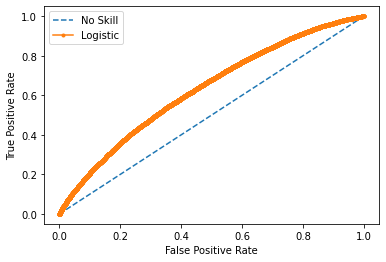

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.629


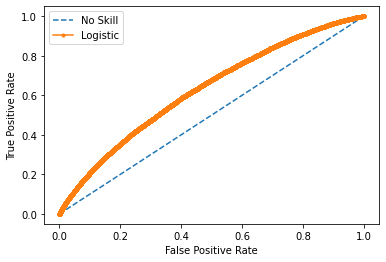

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.631


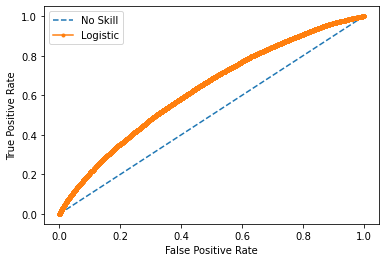

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


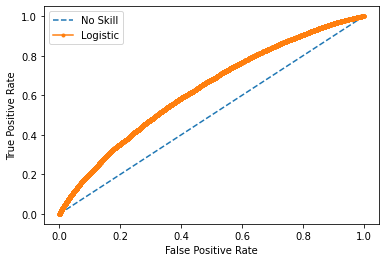

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.629


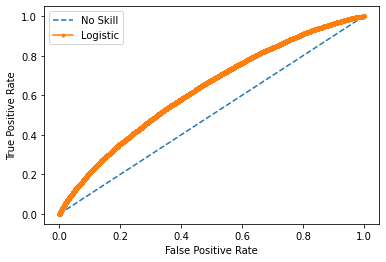

,AUC Train,AUC Test
0,0.705813,0.631612
1,0.709070,0.629110
2,0.708835,0.630959
3,0.706202,0.629806
4,0.709749,0.629059


In [136]:
xgb_model = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    xgb_model.fit(X_train.iloc[train], y_train.iloc[train])
    y_train_preds = xgb_model.predict_proba(X_train)
    y_preds = xgb_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_train, y_train_preds[:,1])
    auc_score_train = roc_auc_score(y_train, y_train_preds[:,1])
    fpr, tpr, _ = roc_curve(y_test, y_preds[:,1])
    auc_score = roc_auc_score(y_test, y_preds[:,1])
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    calculate_roc(y_test, y_preds[:,1])
    
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])



In [137]:
scoring = ['precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_model, X_train, y_train, scoring=scoring)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [138]:
scores

{'fit_time': array([15.33999872, 14.66300106, 14.70900512, 14.78799963, 15.2629993 ]),
 'score_time': array([0.20000005, 0.20999908, 0.22599459, 0.21000099, 0.20600009]),
 'test_precision_macro': array([0.62100048, 0.62342355, 0.62285616, 0.62521925, 0.62016782]),
 'test_recall_macro': array([0.62075472, 0.6232345 , 0.62277628, 0.62506739, 0.62008086]),
 'test_f1_macro': array([0.62056205, 0.62309017, 0.62271495, 0.62495367, 0.62001212])}

In [139]:
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2))

Recall: 0.62 (+/- 0.00)
Precision: 0.62 (+/- 0.00)
F1: 0.62 (+/- 0.00)


## Entrenar y evaluar Modelos

### Regresión Logística

In [140]:
from sklearn.linear_model import LogisticRegression

In [141]:
LogisticRegression()

LogisticRegression()

In [142]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=10000)

In [143]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [144]:
y_preds = logreg.predict_proba(X_test)

In [145]:
param_grid = { 
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.001,0.1,1,10,100]
}

In [146]:
CV_rfc = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5)

In [147]:
CV_rfc.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__C': 0.1,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 10000,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=0.1, max_iter=10000),
 'iid': 'deprecated',
 'n_jobs': 6,
 'param_grid': {'solver': ['lbfgs', 'liblinear'],
  'C': [0.001, 0.1, 1, 10, 100]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 5}

In [148]:
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done  14 out of  20 | elapsed:   10.7s remaining:    4.5s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   13.0s finished


GridSearchCV(cv=2, estimator=LogisticRegression(C=0.1, max_iter=10000),
             n_jobs=6,
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=5)

In [149]:
CV_rfc.best_estimator_.score(X_test,y_test)

0.5660977849926309

In [150]:
CV_rfc.best_score_

0.5615579514824798

In [151]:
CV_rfc.cv_results_

{'mean_fit_time': array([1.12900019, 3.14900208, 1.21150267, 3.65298057, 1.29350317,
        3.70200086, 1.35451078, 3.41549408, 1.40801048, 2.27349448]),
 'std_fit_time': array([0.29499793, 0.05999923, 0.37649858, 0.04299879, 0.34150064,
        0.01297832, 0.38550878, 0.11850798, 0.37500954, 0.10749841]),
 'mean_score_time': array([0.06999028, 0.07198942, 0.06600058, 0.05601728, 0.08498764,
        0.07549393, 0.06948841, 0.04100895, 0.06350148, 0.02850258]),
 'std_score_time': array([0.01001203, 0.01298797, 0.01100004, 0.00700223, 0.0190084 ,
        0.01248705, 0.0075115 , 0.00099421, 0.00450027, 0.00250137]),
 'param_C': masked_array(data=[0.001, 0.001, 0.1, 0.1, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'liblinear', 'lbfgs', 'liblinear', 'lbfgs',
                    'liblinear', 'lbfgs', 'lib

In [175]:
print(classification_report(y_test,y_preds[:,1])>0.5)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [176]:
print(classification_report(y_test,y_preds[:,1]>0.4))

              precision    recall  f1-score   support

         0.0       0.84      0.06      0.12     30906
         1.0       0.35      0.98      0.51     15911

    accuracy                           0.37     46817
   macro avg       0.60      0.52      0.32     46817
weighted avg       0.67      0.37      0.25     46817



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.624


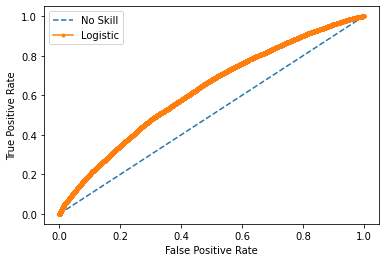

In [177]:
calculate_roc(y_test,y_preds[:,1])

#### Decision Tree

In [178]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=6)

In [179]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [180]:
preds = tree.predict(X_test)
y_preds = tree.predict_proba(X_test)

In [181]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.74      0.59      0.65     30906
         1.0       0.42      0.59      0.49     15911

    accuracy                           0.59     46817
   macro avg       0.58      0.59      0.57     46817
weighted avg       0.63      0.59      0.60     46817



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.623


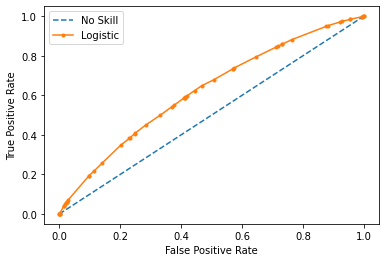

In [182]:
calculate_roc(y_test, y_preds[:,1])


In [183]:
columnas_entrenamiento = [x for x in df.columns if x != 'target2']

In [184]:
features = pd.DataFrame(list(zip(columnas_entrenamiento,tree.feature_importances_))).sort_values(by=1,ascending=False)[:10]

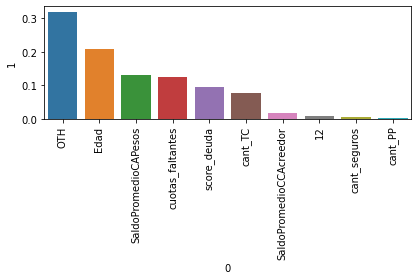

In [185]:
sns.barplot(features.loc[:,0],features.loc[:,1])
plt.xticks(rotation=90)
plt.tight_layout()

In [186]:
tree.get_depth()

6

### Random Forest

In [187]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [188]:
rfc

RandomForestClassifier(max_depth=4, random_state=42)

In [189]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [190]:
preds=rfc.predict(X_test)
y_preds = rfc.predict_proba(X_test)

In [191]:
print(classification_report(y_test,y_preds[:,1]>0.4))

              precision    recall  f1-score   support

         0.0       0.84      0.06      0.12     30906
         1.0       0.35      0.98      0.51     15911

    accuracy                           0.37     46817
   macro avg       0.60      0.52      0.32     46817
weighted avg       0.67      0.37      0.25     46817



In [192]:
(y_preds[:,1]>0.35).sum()

46730

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.624


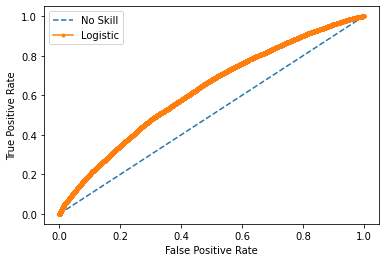

In [193]:
calculate_roc(y_test, y_preds[:,1])

In [194]:
rfc=RandomForestClassifier(n_estimators=1000, max_depth=8, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=42)

In [195]:
preds=rfc.predict(X_test)
y_preds = rfc.predict_proba(X_test)

In [196]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.74      0.60      0.66     30906
         1.0       0.43      0.59      0.50     15911

    accuracy                           0.60     46817
   macro avg       0.59      0.60      0.58     46817
weighted avg       0.64      0.60      0.61     46817



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.636


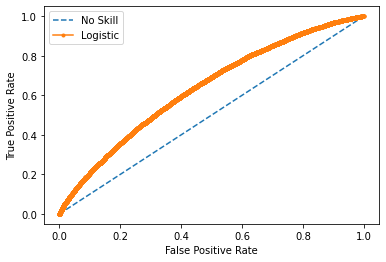

In [197]:
calculate_roc(y_test, y_preds[:,1])

In [198]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [199]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [200]:
xgbrf_model.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [201]:
preds = xgbrf_model.predict(X_test)
y_preds = xgbrf_model.predict_proba(X_test)

In [202]:
print(classification_report(y_test,y_preds[:,1]>0.30))

              precision    recall  f1-score   support

         0.0       0.87      0.04      0.08     30906
         1.0       0.35      0.99      0.51     15911

    accuracy                           0.36     46817
   macro avg       0.61      0.52      0.30     46817
weighted avg       0.69      0.36      0.23     46817



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


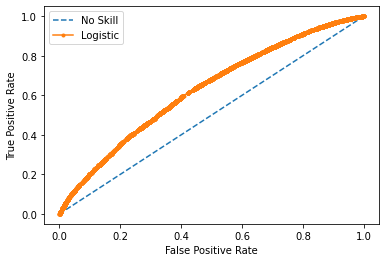

In [203]:
calculate_roc(y_test, y_preds[:,1])

In [ ]:
preds = xgbrf_model.predict(X_test)
y_preds = xgbrf_model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,preds))

In [ ]:
calculate_roc(y_test, y_preds[:,1])

## Probar con distintos hiperparámetros y con distintos umbrales

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5)

In [ ]:
CV_rfc

In [ ]:
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_score_

In [ ]:
CV_rfc.best_estimator_

In [ ]:
CV_rfc.best_params_

In [ ]:
preds = CV_rfc.predict(X_test)

In [ ]:
print(classification_report(y_test,preds))

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(probability=False,kernel='linear')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, y_pred[:,1]>0.7))

In [ ]:
(y_pred[:,1]>0.4).sum()

In [ ]:
calculate_roc(y_test,y_pred[:,1])